# Object Detection

## Task 2: Apply and Analyze Object Detection Models

by Dechathon Niamsa-ard [st126235]


**Goal:** Compare a **two-stage** detector and a **single-stage** detector.

**Recommended Models:**

- Two-stage: [Faster R-CNN (TorchVision)]
- Single-stage: YOLO v11

**Dataset Options:**

- [COCO 2017 (Mini subset)] — 128 annotated images
- [Pascal VOC 2007]

**Instructions:**

1. Run both detectors on the same dataset.
2. Measure:
- Detection accuracy (mAP or precision-recall curves)
- Inference speed (FPS)
- Model size and memory usage
3. Visualize 5–10 images with predicted bounding boxes.
4. Optionally, test reduced input resolutions or lightweight model variants.

**Deliverables:**

- Notebook with detection and evaluation pipeline
- Quantitative comparison table
- Example detection results
- Short discussion on performance trade-offs

---

##  Import necessary libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ultralytics
from ultralytics import YOLO
import torchvision.transforms as transforms
import torchvision.models.detection as detection
import cv2
from PIL import Image, ImageDraw, ImageFont
import time
import os
import pandas as pd

## Setup Config

## Make sure the torch is using GPU

In [2]:
!nvidia-smi

Fri Oct 31 08:53:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.88                 Driver Version: 580.88         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5060 Ti   WDDM  |   00000000:02:00.0 Off |                  N/A |
|  0%   37C    P8              2W /  180W |      31MiB /  16311MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Download Dataset: COCO 2017 (Mini subset)

In [4]:
# Download COCO 2017 (mini subset) dataset via kagglehub: https://www.kaggle.com/datasets/ultralytics/coco128
import kagglehub
import shutil

# Download the dataset to the default cache.
# The function returns the path to the downloaded files in the cache.
print("Downloading dataset via kagglehub")
download_path = kagglehub.dataset_download("ultralytics/coco128")
print(f"Dataset downloaded to cache: {download_path}")

# Move files to the current working directory
# Get the current directory path for confirmation message.
current_dir = os.getcwd()
print(f"\nMoving dataset files to the current directory: {current_dir}")

# List all files/folders in the downloaded path.
for item_name in os.listdir(download_path):
    source_item = os.path.join(download_path, item_name)
    destination_item = os.path.join(current_dir, item_name)
    
    # Use shutil.move to transfer the item.
    # This will overwrite existing files/folders with the same name.
    shutil.move(source_item, destination_item)
    print(f" - Moved '{item_name}'")

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to cache: C:\Users\USER\.cache\kagglehub\datasets\ultralytics\coco128\versions\3

Moving dataset files to the current directory: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2


In [5]:
# Create a list of class names ordered by their class IDs
COCO_CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 
                'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
                'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
print(f"COCO class names: {COCO_CLASSES}")

COCO class names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Prepare Models

### Training Configuration

**Important Notes:**
- Both models will be trained for **20 epochs** for fair comparison
- Transfer learning approach: Starting with pretrained weights and fine-tuning
- Faster R-CNN: Batch size 2, SGD optimizer (lr=0.005)
- YOLOv8: Batch size 8, built-in optimizer configuration
- Dataset: COCO128 (128 images) split for training

In [6]:
# Prepare the dataset 
from torch.utils.data import Dataset, DataLoader
import json

# Path to dataset
dataset_path = 'coco128'
images_path = os.path.join(dataset_path, 'images', 'train2017')
labels_path = os.path.join(dataset_path, 'labels', 'train2017')

# Get all image files
image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
print(f"Found {len(image_files)} images in dataset")

# Create a custom dataset class for evaluation
class COCO128Dataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Load labels (YOLO format: class x_center y_center width height)
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.labels_path, label_name)
        
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Convert YOLO format to absolute coordinates
                        img_width, img_height = image.size
                        x1 = (x_center - width / 2) * img_width
                        y1 = (y_center - height / 2) * img_height
                        x2 = (x_center + width / 2) * img_width
                        y2 = (y_center + height / 2) * img_height
                        
                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id)
        
        return {
            'image': image,
            'image_path': img_path,
            'boxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4)),
            'labels': torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        }

# Create dataset instance
dataset = COCO128Dataset(images_path, labels_path)
print(f"Dataset prepared with {len(dataset)} images")

Found 128 images in dataset
Dataset prepared with 128 images


### 1. Two-stage: Faster R-CNN

We'll use transfer learning - starting with pretrained weights and fine-tuning on COCO128.

In [7]:
# Prepare dataset for Faster R-CNN training
from torch.utils.data import DataLoader
import torch.optim as optim

class FasterRCNNDataset(Dataset):
    """Dataset class compatible with Faster R-CNN training"""
    def __init__(self, images_path, labels_path, transforms=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        
        # Load labels
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.labels_path, label_name)
        
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0]) + 1  # Faster R-CNN uses 1-indexed (0 is background)
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Convert to absolute coordinates
                        img_width, img_height = image.size
                        x1 = (x_center - width / 2) * img_width
                        y1 = (y_center - height / 2) * img_height
                        x2 = (x_center + width / 2) * img_width
                        y2 = (y_center + height / 2) * img_height
                        
                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id)
        
        # Convert to tensors
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }
        
        return image_tensor, target

# Create training dataset
train_dataset_rcnn = FasterRCNNDataset(images_path, labels_path)
print(f"Faster R-CNN training dataset: {len(train_dataset_rcnn)} images")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader_rcnn = DataLoader(
    train_dataset_rcnn,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)
print("DataLoader created")

Faster R-CNN training dataset: 128 images
DataLoader created


In [8]:
# Load Faster R-CNN with pretrained backbone for transfer learning
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# Initialize with pretrained weights for transfer learning
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
faster_rcnn = fasterrcnn_resnet50_fpn(weights=weights)
faster_rcnn = faster_rcnn.to(device)

print("Faster R-CNN model initialized with pretrained weights")
print(f"Model on device: {next(faster_rcnn.parameters()).device}")

# Get model size
faster_rcnn_size = sum(p.numel() for p in faster_rcnn.parameters()) / 1e6
print(f"Faster R-CNN parameters: {faster_rcnn_size:.2f}M")

Faster R-CNN model initialized with pretrained weights
Model on device: cuda:0
Faster R-CNN parameters: 41.76M


In [9]:
# Train Faster R-CNN on COCO128
print("Training Faster R-CNN...")

# Set model to training mode
faster_rcnn.train()

# Optimizer
params = [p for p in faster_rcnn.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training configuration - SAME AS YOLO FOR FAIR COMPARISON
num_epochs = 10
print(f"Training for {num_epochs} epochs...")

# Track metrics like YOLO for comparison
training_losses = []
training_box_losses = []
training_cls_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_box_loss = 0
    epoch_cls_loss = 0
    num_batches = 0
    
    for images, targets in train_loader_rcnn:
        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = faster_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Track individual losses
        box_loss = loss_dict.get('loss_box_reg', torch.tensor(0.0))
        cls_loss = loss_dict.get('loss_classifier', torch.tensor(0.0))
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        epoch_box_loss += box_loss.item()
        epoch_cls_loss += cls_loss.item()
        num_batches += 1
    
    # Update learning rate
    lr_scheduler.step()
    
    avg_loss = epoch_loss / num_batches
    avg_box_loss = epoch_box_loss / num_batches
    avg_cls_loss = epoch_cls_loss / num_batches
    
    training_losses.append(avg_loss)
    training_box_losses.append(avg_box_loss)
    training_cls_losses.append(avg_cls_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {avg_loss:.4f}, Box Loss: {avg_box_loss:.4f}, Cls Loss: {avg_cls_loss:.4f}")

print("Training completed!")

# Set to evaluation mode
faster_rcnn.eval()

# Save training metrics to CSV for comparison
import pandas as pd
rcnn_metrics = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train/total_loss': training_losses,
    'train/box_loss': training_box_losses,
    'train/cls_loss': training_cls_losses
})

# Create model_task2 folder if it doesn't exist
os.makedirs('model_task2', exist_ok=True)
rcnn_metrics.to_csv('model_task2/faster_rcnn_training_results.csv', index=False)
print("\nTraining metrics saved to: model_task2/faster_rcnn_training_results.csv")

Training Faster R-CNN...
Training for 10 epochs...
Epoch 1/10, Total Loss: 1.1209, Box Loss: 0.2784, Cls Loss: 0.6760
Epoch 1/10, Total Loss: 1.1209, Box Loss: 0.2784, Cls Loss: 0.6760
Epoch 2/10, Total Loss: 0.9092, Box Loss: 0.2745, Cls Loss: 0.5279
Epoch 3/10, Total Loss: 0.7351, Box Loss: 0.2426, Cls Loss: 0.4081
Epoch 4/10, Total Loss: 0.5892, Box Loss: 0.2152, Cls Loss: 0.3029
Epoch 5/10, Total Loss: 0.5132, Box Loss: 0.1873, Cls Loss: 0.2737
Epoch 6/10, Total Loss: 0.4901, Box Loss: 0.1787, Cls Loss: 0.2627
Epoch 7/10, Total Loss: 0.4585, Box Loss: 0.1674, Cls Loss: 0.2450
Epoch 8/10, Total Loss: 0.4556, Box Loss: 0.1665, Cls Loss: 0.2431
Epoch 9/10, Total Loss: 0.4542, Box Loss: 0.1665, Cls Loss: 0.2430
Epoch 10/10, Total Loss: 0.4487, Box Loss: 0.1640, Cls Loss: 0.2403
Training completed!

Training metrics saved to: model_task2/faster_rcnn_training_results.csv


In [10]:
# Save Faster R-CNN model and calculate file size
import tempfile
print("Saving Faster R-CNN model...")

# Save model to model_task2 folder
os.makedirs('model_task2', exist_ok=True)
model_path = 'model_task2/faster_rcnn_coco128.pth'
torch.save(faster_rcnn.state_dict(), model_path)
print(f"Faster R-CNN model saved to: {model_path}")

# Calculate model file size
faster_rcnn_file_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"Faster R-CNN model file size: {faster_rcnn_file_size:.2f} MB")

Saving Faster R-CNN model...
Faster R-CNN model saved to: model_task2/faster_rcnn_coco128.pth
Faster R-CNN model file size: 159.79 MB


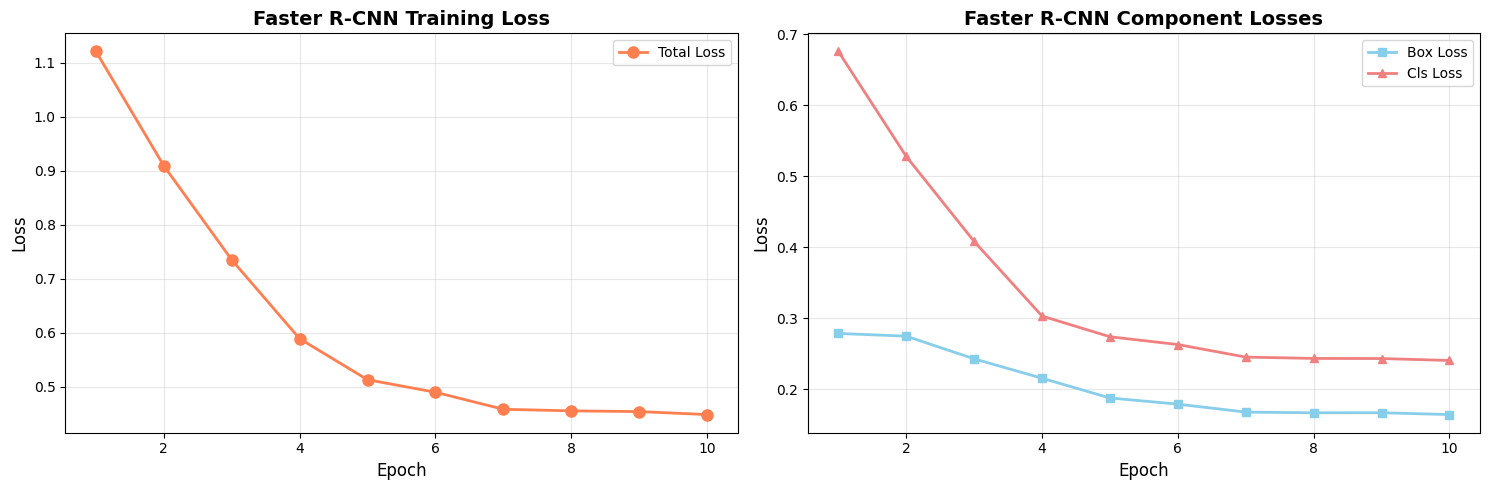

In [11]:
# Plot Faster R-CNN training curves (similar style to YOLO)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total Loss
axes[0].plot(range(1, num_epochs + 1), training_losses, 
             marker='o', linewidth=2, markersize=8, color='coral', label='Total Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Faster R-CNN Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Box Loss and Classification Loss
axes[1].plot(range(1, num_epochs + 1), training_box_losses, 
             marker='s', linewidth=2, markersize=6, color='skyblue', label='Box Loss')
axes[1].plot(range(1, num_epochs + 1), training_cls_losses, 
             marker='^', linewidth=2, markersize=6, color='lightcoral', label='Cls Loss')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Faster R-CNN Component Losses', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

### 2. Single-stage: YOLOv11

We'll train YOLOv11 on the COCO128 dataset using Ultralytics' built-in training pipeline.

In [12]:
# Prepare YAML configuration file for YOLOv8 training
yaml_content = f"""
# COCO128 dataset configuration
path: {os.path.abspath(dataset_path)}  # dataset root dir
train: images/train2017  # train images (relative to 'path')
val: images/train2017  # val images (same as train for this small dataset)

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

# Save YAML file
yaml_path = 'coco128_custom.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"YAML configuration saved to: {yaml_path}")

YAML configuration saved to: coco128_custom.yaml


In [13]:
# Train YOLOv11 on COCO128
print("Training YOLOv11n...")

# Initialize model with YOLOv11n pretrained weights
yolo_model = YOLO('yolo11n.pt')  # Using v11n

# Train the model
results = yolo_model.train(
    data=yaml_path,
    epochs=10,
    imgsz=640,
    batch=8,
    device=device,
    project='model_task2',
    name='yolov11n_coco128_run',
    verbose=True,
    patience=5,
    save=True
)

print("YOLOv11n training completed!")
print(f"Best model saved at: {yolo_model.trainer.best}")

Training YOLOv11n...
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128_custom.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_coco128_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 680.0338.7 MB/s, size: 46.0 KB)
train: Scanning C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\coco128\labels\train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 441.5Kit/s 0.0s
val: Fast image access  (ping: 0.00.0 ms, read: 376.8127.9 MB/s, size: 56.4 KB)
val: Scanning C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\coco128\labels\train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 132.7Kit/s 0.0s
Plotting labels to C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_task2\yolov11n_coco128_run\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 81 weight(deca

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       1/10      6.76G      1.198       1.31      1.279         58        640: 6% ╸─────────── 1/16 2.9it/s 2.2s<5.2s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/10      6.78G      1.195      1.519      1.231         42        640: 100% ━━━━━━━━━━━━ 16/16 4.8it/s 3.4s<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.4it/s 3.4s0.3ss
                   all        128        929      0.678      0.594      0.685      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10       6.8G      1.264      1.508      1.248         79        640: 6% ╸─────────── 1/16 1.7it/s 0.2s<8.7s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       2/10       6.8G      1.186      1.341      1.198         60        640: 100% ━━━━━━━━━━━━ 16/16 13.9it/s 1.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.6it/s 0.5s.2s
                   all        128        929      0.676      0.601      0.697       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10       6.8G     0.9964       1.23       1.26         28        640: 6% ╸─────────── 1/16 2.1it/s 0.1s<7.3s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       3/10       6.8G       1.11      1.377      1.216         51        640: 100% ━━━━━━━━━━━━ 16/16 13.1it/s 1.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.9it/s 0.5s.2s
                   all        128        929      0.673      0.614      0.693      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/10       6.8G      1.119      1.237      1.215         23        640: 6% ╸─────────── 1/16 2.1it/s 0.1s<7.2s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       4/10       6.8G      1.127      1.229       1.18         28        640: 100% ━━━━━━━━━━━━ 16/16 15.1it/s 1.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 15.0it/s 0.5s.2s
                   all        128        929      0.681      0.619      0.695      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/10       6.8G      1.132      1.018      1.345         19        640: 6% ╸─────────── 1/16 2.1it/s 0.1s<7.0s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       5/10       6.8G       1.12      1.165      1.166         48        640: 100% ━━━━━━━━━━━━ 16/16 15.1it/s 1.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.8it/s 0.5s.2s
                   all        128        929       0.71      0.611        0.7      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/10       6.8G      1.118      1.255       1.14         49        640: 6% ╸─────────── 1/16 2.4it/s 0.1s<6.3s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       6/10       6.8G      1.148      1.225      1.167         63        640: 100% ━━━━━━━━━━━━ 16/16 15.3it/s 1.0s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.8it/s 0.5s.2s
                   all        128        929      0.717      0.598      0.699       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/10       6.8G      1.134      1.242      1.213         49        640: 6% ╸─────────── 1/16 2.4it/s 0.1s<6.3s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       7/10      6.81G      1.128      1.165      1.189         41        640: 100% ━━━━━━━━━━━━ 16/16 15.3it/s 1.0s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.9it/s 0.5s.2s
                   all        128        929      0.764      0.592      0.706      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/10      6.81G      1.014     0.9774      1.107         84        640: 6% ╸─────────── 1/16 2.3it/s 0.1s<6.4s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       8/10      6.81G      1.121      1.139      1.176         65        640: 100% ━━━━━━━━━━━━ 16/16 15.3it/s 1.0s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.9it/s 0.5s.2s
                   all        128        929      0.682      0.646      0.708      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/10      6.81G      1.205      1.426      1.293         43        640: 6% ╸─────────── 1/16 2.4it/s 0.1s<6.2s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       9/10      6.81G       1.08      1.104       1.16         67        640: 100% ━━━━━━━━━━━━ 16/16 15.6it/s 1.0s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 14.9it/s 0.5s.2s
                   all        128        929      0.706      0.637      0.709      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/10      6.81G      1.225      1.083      1.257         61        640: 6% ╸─────────── 1/16 2.4it/s 0.1s<6.2s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

      10/10      6.81G      1.103      1.092      1.139         62        640: 100% ━━━━━━━━━━━━ 16/16 15.5it/s 1.0s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 15.1it/s 0.5s.2s
                   all        128        929      0.716      0.634      0.709      0.546

10 epochs completed in 0.009 hours.
Optimizer stripped from C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_task2\yolov11n_coco128_run\weights\last.pt, 5.5MB
Optimizer stripped from C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_task2\yolov11n_coco128_run\weights\best.pt, 5.5MB

Validating C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_task2\yolov11n_coco128_run\weights\best.pt...
Ultralytics 8.3.221  Python-3.13.9 torch-2.9.0+cu130 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
YOLO11n summary (fused): 100 layers, 

In [14]:
# Load the best trained YOLOv11n model
yolo_model = YOLO('model_task2/yolov11n_coco128_run/weights/best.pt')
yolo_model.to(device)

print("YOLOv11n best model loaded successfully")
print(f"Model path: model_task2/yolov11n_coco128_run/weights/best.pt")

# Get model size
yolo_size = sum(p.numel() for p in yolo_model.model.parameters()) / 1e6
print(f"YOLOv11n parameters: {yolo_size:.2f}M")

# Get model file size
yolo_file_size = os.path.getsize('model_task2/yolov11n_coco128_run/weights/best.pt') / (1024 * 1024)
print(f"YOLOv11n model file size: {yolo_file_size:.2f} MB")

YOLOv11n best model loaded successfully
Model path: model_task2/yolov11n_coco128_run/weights/best.pt
YOLOv11n parameters: 2.62M
YOLOv11n model file size: 5.27 MB


In [15]:
# Display training results
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

# YOLOv11 training metrics
yolo_results_path = 'model_task2/yolov11n_coco128_run/results.csv'
if os.path.exists(yolo_results_path):
    results_df = pd.read_csv(yolo_results_path)
    results_df = results_df.rename(columns=lambda x: x.strip())
    
    print("\nYOLOv11n Training Metrics (Last 3 Epochs):")
    print(results_df[['epoch', 'train/box_loss', 'train/cls_loss', 'metrics/mAP50(B)']].tail(3).to_string(index=False))
else:
    print("\nYOLOv11n results not found")

# Faster R-CNN training metrics
rcnn_results_path = 'model_task2/faster_rcnn_training_results.csv'
if os.path.exists(rcnn_results_path):
    rcnn_df = pd.read_csv(rcnn_results_path)
    print("\nFaster R-CNN Training Metrics (Last 3 Epochs):")
    print(rcnn_df[['epoch', 'train/total_loss', 'train/box_loss', 'train/cls_loss']].tail(3).to_string(index=False))
else:
    print("\nFaster R-CNN Training Losses:")
    for i, loss in enumerate(training_losses, 1):
        print(f"  Epoch {i}: {loss:.4f}")

print("="*70)
print("\nBoth models saved in 'model_task2' folder:")
print("   - Faster R-CNN: model_task2/faster_rcnn_coco128.pth")
print("   - YOLOv11n: model_task2/yolov11n_coco128_run/weights/best.pt")
print("="*70)


TRAINING SUMMARY

YOLOv11n Training Metrics (Last 3 Epochs):
 epoch  train/box_loss  train/cls_loss  metrics/mAP50(B)
     8         1.12128         1.13927           0.70767
     9         1.08039         1.10381           0.70854
    10         1.10264         1.09238           0.70905

Faster R-CNN Training Metrics (Last 3 Epochs):
 epoch  train/total_loss  train/box_loss  train/cls_loss
     8          0.455616        0.166492        0.243146
     9          0.454247        0.166544        0.242990
    10          0.448731        0.163976        0.240261

Both models saved in 'model_task2' folder:
   - Faster R-CNN: model_task2/faster_rcnn_coco128.pth
   - YOLOv11n: model_task2/yolov11n_coco128_run/weights/best.pt


Training comparison plot saved to: model_task2/training_comparison.png


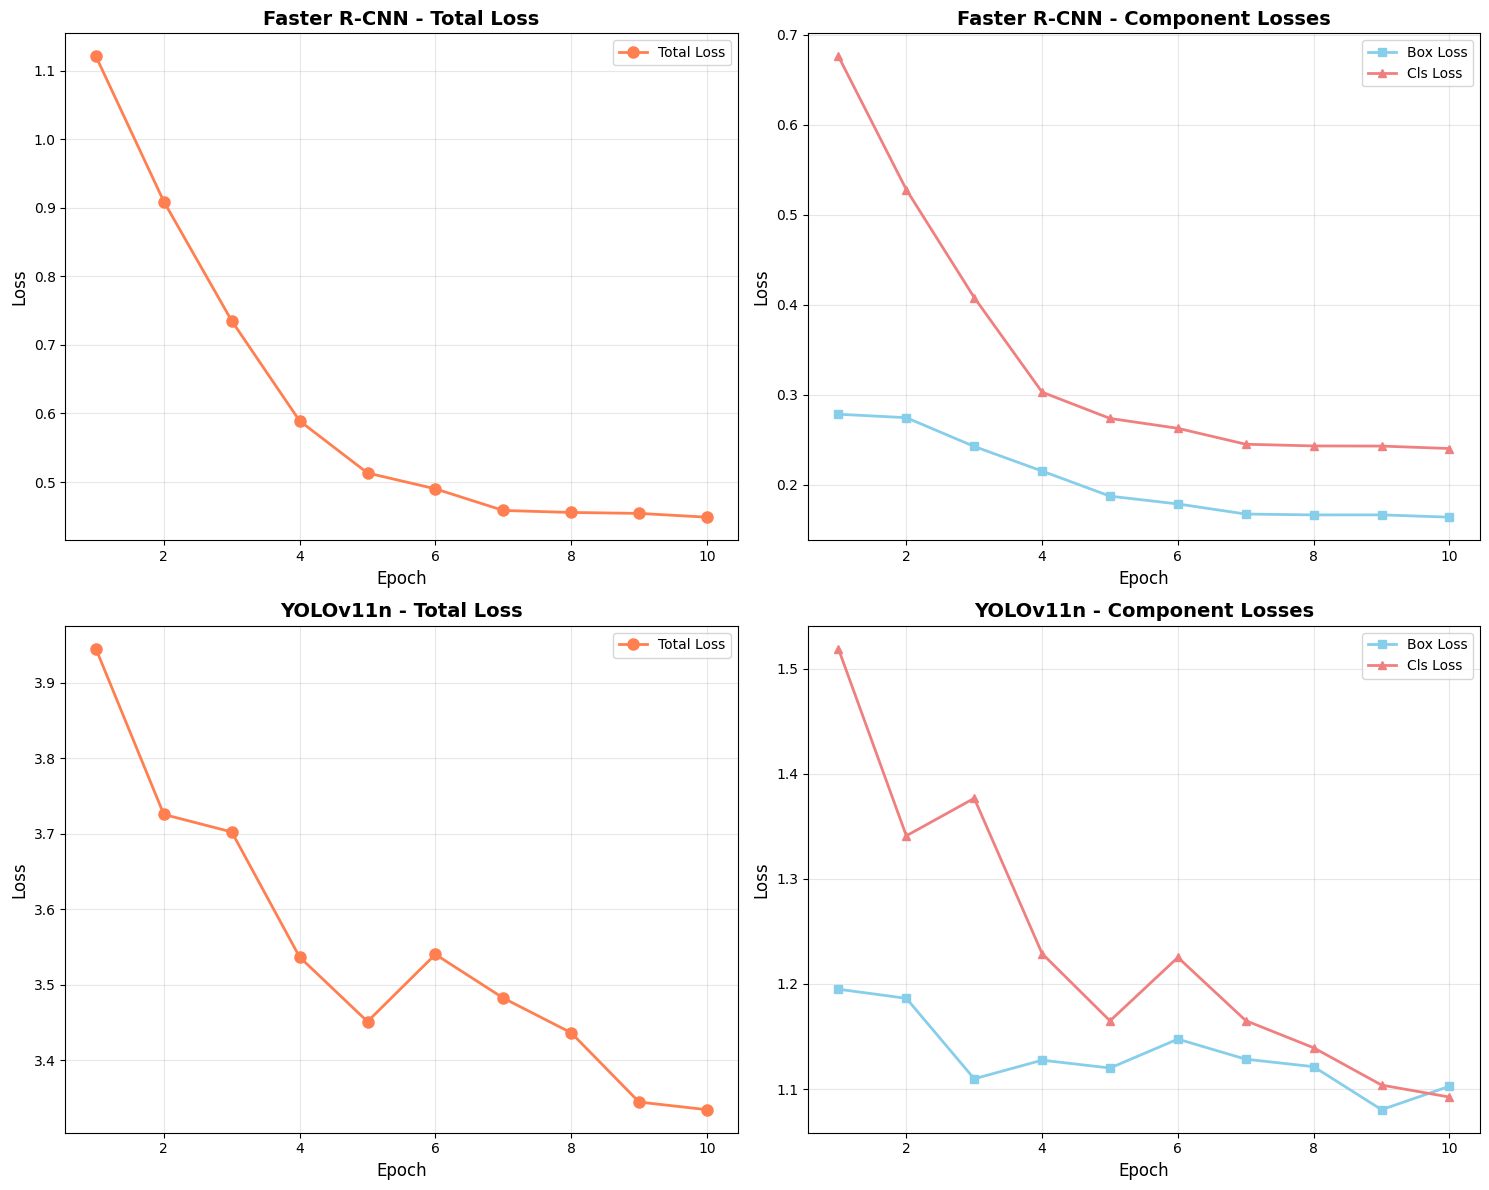

In [16]:
# Plot training curves comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Load both training results
yolo_results_path = 'model_task2/yolov11n_coco128_run/results.csv'
rcnn_results_path = 'model_task2/faster_rcnn_training_results.csv'

# Row 1: Faster R-CNN
axes[0, 0].plot(range(1, len(training_losses) + 1), training_losses, 
                marker='o', linewidth=2, markersize=8, color='coral', label='Total Loss')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Faster R-CNN - Total Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(range(1, len(training_box_losses) + 1), training_box_losses, 
                marker='s', linewidth=2, markersize=6, color='skyblue', label='Box Loss')
axes[0, 1].plot(range(1, len(training_cls_losses) + 1), training_cls_losses, 
                marker='^', linewidth=2, markersize=6, color='lightcoral', label='Cls Loss')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Faster R-CNN - Component Losses', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Row 2: YOLOv11
if os.path.exists(yolo_results_path):
    results_df = pd.read_csv(yolo_results_path)
    results_df = results_df.rename(columns=lambda x: x.strip())
    
    # Total loss (sum of box + cls + dfl losses)
    total_loss = results_df['train/box_loss'] + results_df['train/cls_loss'] + results_df['train/dfl_loss']
    axes[1, 0].plot(results_df['epoch'], total_loss, 
                    marker='o', linewidth=2, markersize=8, color='coral', label='Total Loss')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss', fontsize=12)
    axes[1, 0].set_title('YOLOv11n - Total Loss', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Component losses
    axes[1, 1].plot(results_df['epoch'], results_df['train/box_loss'], 
                    marker='s', linewidth=2, markersize=6, color='skyblue', label='Box Loss')
    axes[1, 1].plot(results_df['epoch'], results_df['train/cls_loss'], 
                    marker='^', linewidth=2, markersize=6, color='lightcoral', label='Cls Loss')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Loss', fontsize=12)
    axes[1, 1].set_title('YOLOv11n - Component Losses', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'YOLOv11n results not available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('YOLOv11n - Total Loss', fontsize=14, fontweight='bold')
    axes[1, 1].text(0.5, 0.5, 'YOLOv11n results not available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('YOLOv11n - Component Losses', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('model_task2/training_comparison.png', dpi=150, bbox_inches='tight')
print("Training comparison plot saved to: model_task2/training_comparison.png")
plt.show()

## Run both model on same dataset

In [17]:
# Helper function for Faster R-CNN inference
def run_faster_rcnn(model, image_path, conf_threshold=0.5):
    """Run Faster R-CNN on a single image"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]
    
    # Filter by confidence threshold
    keep = predictions['scores'] >= conf_threshold
    boxes = predictions['boxes'][keep].cpu().numpy()
    labels = predictions['labels'][keep].cpu().numpy()
    scores = predictions['scores'][keep].cpu().numpy()
    
    return boxes, labels, scores

# Helper function for YOLOv11 inference
def run_yolo(model, image_path, conf_threshold=0.5):
    """Run YOLOv11 on a single image"""
    results = model(image_path, conf=conf_threshold, verbose=False)[0]
    
    boxes = results.boxes.xyxy.cpu().numpy()
    labels = results.boxes.cls.cpu().numpy().astype(int)
    scores = results.boxes.conf.cpu().numpy()
    
    return boxes, labels, scores

print("Inference functions defined")

Inference functions defined


In [18]:
# Run both models on the entire dataset and collect predictions
print("Running inference on all images...")

faster_rcnn_predictions = []
yolo_predictions = []

conf_threshold = 0.25  # Lower threshold to get more detections for mAP calculation

# Run inference on all images
for idx in range(len(dataset)):
    sample = dataset[idx]
    image_path = sample['image_path']
    
    # Faster R-CNN
    rcnn_boxes, rcnn_labels, rcnn_scores = run_faster_rcnn(faster_rcnn, image_path, conf_threshold)
    faster_rcnn_predictions.append({
        'boxes': rcnn_boxes,
        'labels': rcnn_labels,
        'scores': rcnn_scores,
        'gt_boxes': sample['boxes'].numpy(),
        'gt_labels': sample['labels'].numpy()
    })
    
    # YOLOv8
    yolo_boxes, yolo_labels, yolo_scores = run_yolo(yolo_model, image_path, conf_threshold)
    yolo_predictions.append({
        'boxes': yolo_boxes,
        'labels': yolo_labels,
        'scores': yolo_scores,
        'gt_boxes': sample['boxes'].numpy(),
        'gt_labels': sample['labels'].numpy()
    })
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(dataset)} images")

print(f"Inference complete on {len(dataset)} images")

Running inference on all images...
Processed 20/128 images
Processed 40/128 images
Processed 60/128 images
Processed 80/128 images
Processed 100/128 images
Processed 120/128 images
Inference complete on 128 images


## Measure Performance Metrics
   - Detection accuracy (mAP or precision-recall curves)
   - Inference speed (FPS)
   - Model size and memory usage

In [19]:
# Calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    """Calculate IoU between two boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

# Calculate Average Precision (AP) for object detection
def calculate_ap(predictions, ground_truths, iou_threshold=0.5, adjust_labels=False):
    """
    Calculate Average Precision for object detection
    
    Args:
        predictions: List of prediction dicts with 'boxes', 'scores', 'labels'
        ground_truths: List of ground truth dicts with 'gt_boxes', 'gt_labels'
        iou_threshold: IoU threshold for matching
        adjust_labels: If True, adjust Faster R-CNN labels (1-indexed) to match YOLO (0-indexed)
    """
    # Collect all predictions and ground truths
    all_predictions = []
    all_ground_truths = []
    
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_scores = pred['scores']
        pred_labels = pred['labels']
        
        gt_boxes = gt['gt_boxes']
        gt_labels = gt['gt_labels']
        
        for i in range(len(pred_boxes)):
            # Adjust label indexing if needed (Faster R-CNN: 1-indexed, YOLO: 0-indexed)
            label = pred_labels[i] - 1 if adjust_labels else pred_labels[i]
            all_predictions.append({
                'box': pred_boxes[i],
                'score': pred_scores[i],
                'label': label,
                'image_idx': len(all_ground_truths)
            })
        
        all_ground_truths.append({
            'boxes': gt_boxes,
            'labels': gt_labels,
            'detected': [False] * len(gt_boxes)
        })
    
    # Sort predictions by score (descending)
    all_predictions.sort(key=lambda x: x['score'], reverse=True)
    
    # Calculate precision and recall
    true_positives = []
    false_positives = []
    
    for pred in all_predictions:
        image_idx = pred['image_idx']
        gt = all_ground_truths[image_idx]
        
        best_iou = 0
        best_gt_idx = -1
        
        # Find best matching ground truth
        for gt_idx in range(len(gt['boxes'])):
            if gt['labels'][gt_idx] == pred['label'] and not gt['detected'][gt_idx]:
                iou = calculate_iou(pred['box'], gt['boxes'][gt_idx])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
        
        # Check if prediction is TP or FP
        if best_iou >= iou_threshold and best_gt_idx >= 0:
            gt['detected'][best_gt_idx] = True
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)
    
    # Calculate cumulative sums
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    
    # Total ground truths
    total_gt = sum(len(gt['boxes']) for gt in all_ground_truths)
    
    # Calculate precision and recall
    recalls = tp_cumsum / (total_gt + 1e-6)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    
    # Calculate AP using 11-point interpolation
    ap = 0
    for t in np.linspace(0, 1, 11):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11
    
    return ap, precisions, recalls

print("Evaluation functions defined")

Evaluation functions defined


In [20]:
# Calculate mAP (mean Average Precision) for both models
print("Calculating mAP for Faster R-CNN...")
# Note: Faster R-CNN uses 1-indexed labels, so we adjust them to match ground truth (0-indexed)
rcnn_ap, rcnn_precisions, rcnn_recalls = calculate_ap(faster_rcnn_predictions, faster_rcnn_predictions, iou_threshold=0.5, adjust_labels=True)

print("Calculating mAP for YOLOv11...")
# YOLOv11 uses 0-indexed labels, matching ground truth
yolo_ap, yolo_precisions, yolo_recalls = calculate_ap(yolo_predictions, yolo_predictions, iou_threshold=0.5, adjust_labels=False)

print(f"\nFaster R-CNN mAP@0.5: {rcnn_ap:.4f}")
print(f"YOLOv11 mAP@0.5: {yolo_ap:.4f}")

Calculating mAP for Faster R-CNN...
Calculating mAP for YOLOv11...

Faster R-CNN mAP@0.5: 0.6548
YOLOv11 mAP@0.5: 0.5878


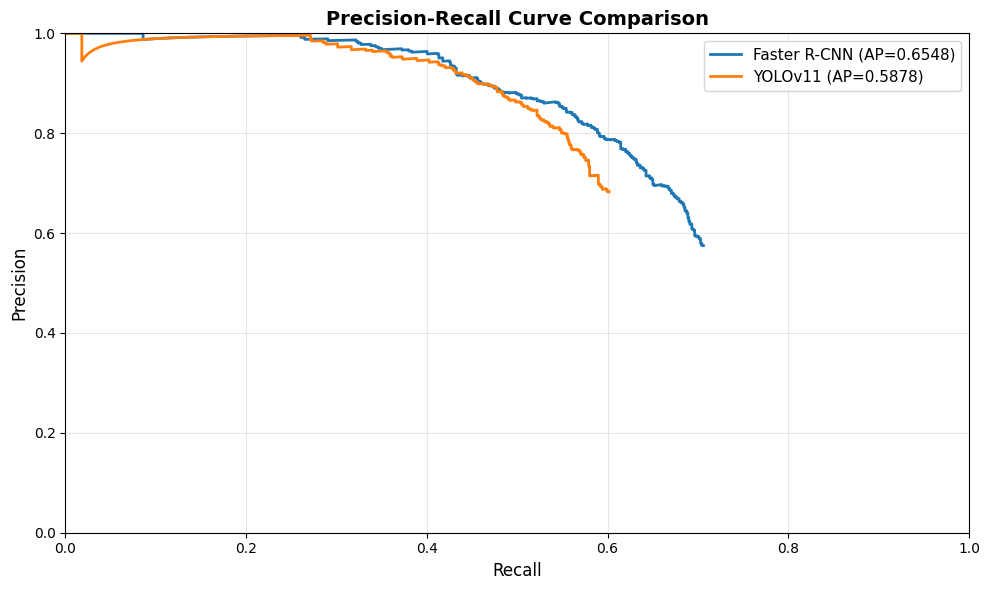

In [21]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(rcnn_recalls, rcnn_precisions, label=f'Faster R-CNN (AP={rcnn_ap:.4f})', linewidth=2)
plt.plot(yolo_recalls, yolo_precisions, label=f'YOLOv11 (AP={yolo_ap:.4f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [22]:
# Measure inference speed (FPS)
print("Measuring inference speed...")

# Select a subset of images for FPS measurement
num_warmup = 10
num_test = 50
test_images = image_files[:num_test]

# Warmup runs
print("Warming up models...")
for i in range(num_warmup):
    img_path = os.path.join(images_path, test_images[i % len(test_images)])
    _ = run_faster_rcnn(faster_rcnn, img_path, conf_threshold=0.5)
    _ = run_yolo(yolo_model, img_path, conf_threshold=0.5)

# Faster R-CNN speed test
print("Testing Faster R-CNN speed...")
start_time = time.time()
for img_name in test_images:
    img_path = os.path.join(images_path, img_name)
    _ = run_faster_rcnn(faster_rcnn, img_path, conf_threshold=0.5)
rcnn_time = time.time() - start_time
rcnn_fps = num_test / rcnn_time

# YOLOv11 speed test
print("Testing YOLOv11 speed...")
start_time = time.time()
for img_name in test_images:
    img_path = os.path.join(images_path, img_name)
    _ = run_yolo(yolo_model, img_path, conf_threshold=0.5)
yolo_time = time.time() - start_time
yolo_fps = num_test / yolo_time

print(f"\nFaster R-CNN: {rcnn_fps:.2f} FPS (avg time: {rcnn_time/num_test*1000:.2f} ms/image)")
print(f"YOLOv11: {yolo_fps:.2f} FPS (avg time: {yolo_time/num_test*1000:.2f} ms/image)")

Measuring inference speed...
Warming up models...
Testing Faster R-CNN speed...
Testing YOLOv11 speed...

Faster R-CNN: 21.18 FPS (avg time: 47.22 ms/image)
YOLOv11: 123.22 FPS (avg time: 8.12 ms/image)


In [23]:
# Measure memory usage
print("Measuring memory usage...")

# Get GPU memory usage for Faster R-CNN
torch.cuda.reset_peak_memory_stats(device)
torch.cuda.empty_cache()

# Run a few inferences
for i in range(5):
    img_path = os.path.join(images_path, test_images[i])
    _ = run_faster_rcnn(faster_rcnn, img_path)

rcnn_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB

# Get GPU memory usage for YOLOv11
torch.cuda.reset_peak_memory_stats(device)
torch.cuda.empty_cache()

# Run a few inferences
for i in range(5):
    img_path = os.path.join(images_path, test_images[i])
    _ = run_yolo(yolo_model, img_path)

yolo_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB

print(f"\nFaster R-CNN peak memory: {rcnn_memory:.2f} MB")
print(f"YOLOv11 peak memory: {yolo_memory:.2f} MB")

Measuring memory usage...

Faster R-CNN peak memory: 1016.38 MB
YOLOv11 peak memory: 594.72 MB


In [24]:
# Create comprehensive comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Model Type',
        'Parameters (M)',
        'Model Size (MB)',
        'mAP@0.5',
        'Inference Speed (FPS)',
        'Avg Time per Image (ms)',
        'Peak GPU Memory (MB)'
    ],
    'Faster R-CNN': [
        'Two-Stage',
        f'{faster_rcnn_size:.2f}',
        f'{faster_rcnn_file_size:.2f}',
        f'{rcnn_ap:.4f}',
        f'{rcnn_fps:.2f}',
        f'{rcnn_time/num_test*1000:.2f}',
        f'{rcnn_memory:.2f}'
    ],
    'YOLOv11': [
        'Single-Stage',
        f'{yolo_size:.2f}',
        f'{yolo_file_size:.2f}',
        f'{yolo_ap:.4f}',
        f'{yolo_fps:.2f}',
        f'{yolo_time/num_test*1000:.2f}',
        f'{yolo_memory:.2f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("QUANTITATIVE COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


QUANTITATIVE COMPARISON TABLE
                 Metric Faster R-CNN      YOLOv11
             Model Type    Two-Stage Single-Stage
         Parameters (M)        41.76         2.62
        Model Size (MB)       159.79         5.27
                mAP@0.5       0.6548       0.5878
  Inference Speed (FPS)        21.18       123.22
Avg Time per Image (ms)        47.22         8.12
   Peak GPU Memory (MB)      1016.38       594.72


## Visualize 5–10 images with predicted bounding boxes.

In [25]:
# Visualization function
def visualize_detections(image_path, rcnn_boxes, rcnn_labels, rcnn_scores, 
                         yolo_boxes, yolo_labels, yolo_scores, conf_threshold=0.5):
    """Visualize detections from both models side by side"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Create two copies for visualization
    img_rcnn = image.copy()
    img_yolo = image.copy()
    
    draw_rcnn = ImageDraw.Draw(img_rcnn)
    draw_yolo = ImageDraw.Draw(img_yolo)
    
    # Try to use a better font, fallback to default if not available
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    
    # Draw Faster R-CNN detections
    for box, label, score in zip(rcnn_boxes, rcnn_labels, rcnn_scores):
        if score >= conf_threshold:
            x1, y1, x2, y2 = box
            draw_rcnn.rectangle([x1, y1, x2, y2], outline='red', width=2)
            
            # Adjust label for COCO classes (Faster R-CNN uses 1-indexed labels)
            class_name = COCO_CLASSES[label - 1] if label <= len(COCO_CLASSES) else f'Class {label}'
            text = f'{class_name}: {score:.2f}'
            draw_rcnn.text((x1, y1 - 15), text, fill='red', font=font)
    
    # Draw YOLOv11 detections
    for box, label, score in zip(yolo_boxes, yolo_labels, yolo_scores):
        if score >= conf_threshold:
            x1, y1, x2, y2 = box
            draw_yolo.rectangle([x1, y1, x2, y2], outline='blue', width=2)
            
            class_name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f'Class {label}'
            text = f'{class_name}: {score:.2f}'
            draw_yolo.text((x1, y1 - 15), text, fill='blue', font=font)
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(img_rcnn)
    axes[0].set_title('Faster R-CNN Detections', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img_yolo)
    axes[1].set_title('YOLOv11 Detections', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization function defined")

Visualization function defined


Visualizing detections on sample images...

Image 1: 000000000009.jpg
  Faster R-CNN detected 5 objects
  YOLOv11 detected 4 objects


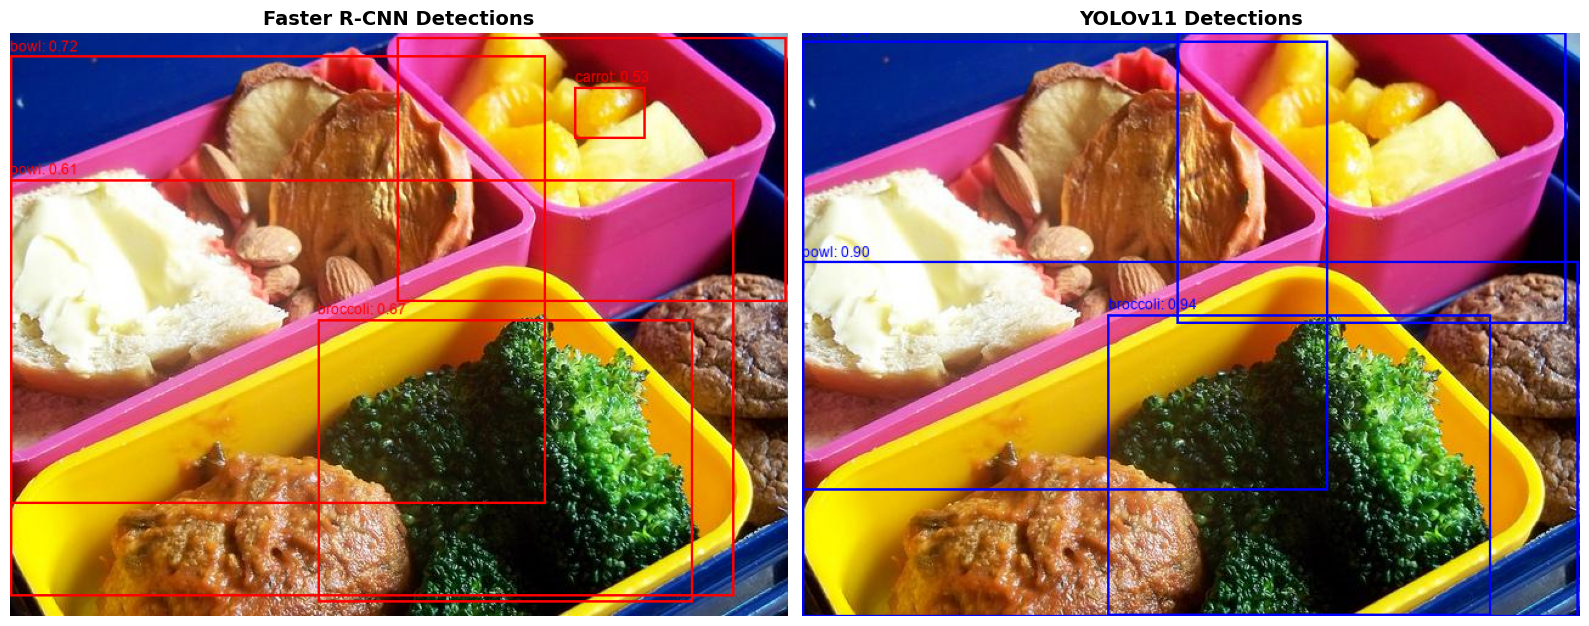


Image 6: 000000000042.jpg
  Faster R-CNN detected 1 objects
  YOLOv11 detected 1 objects


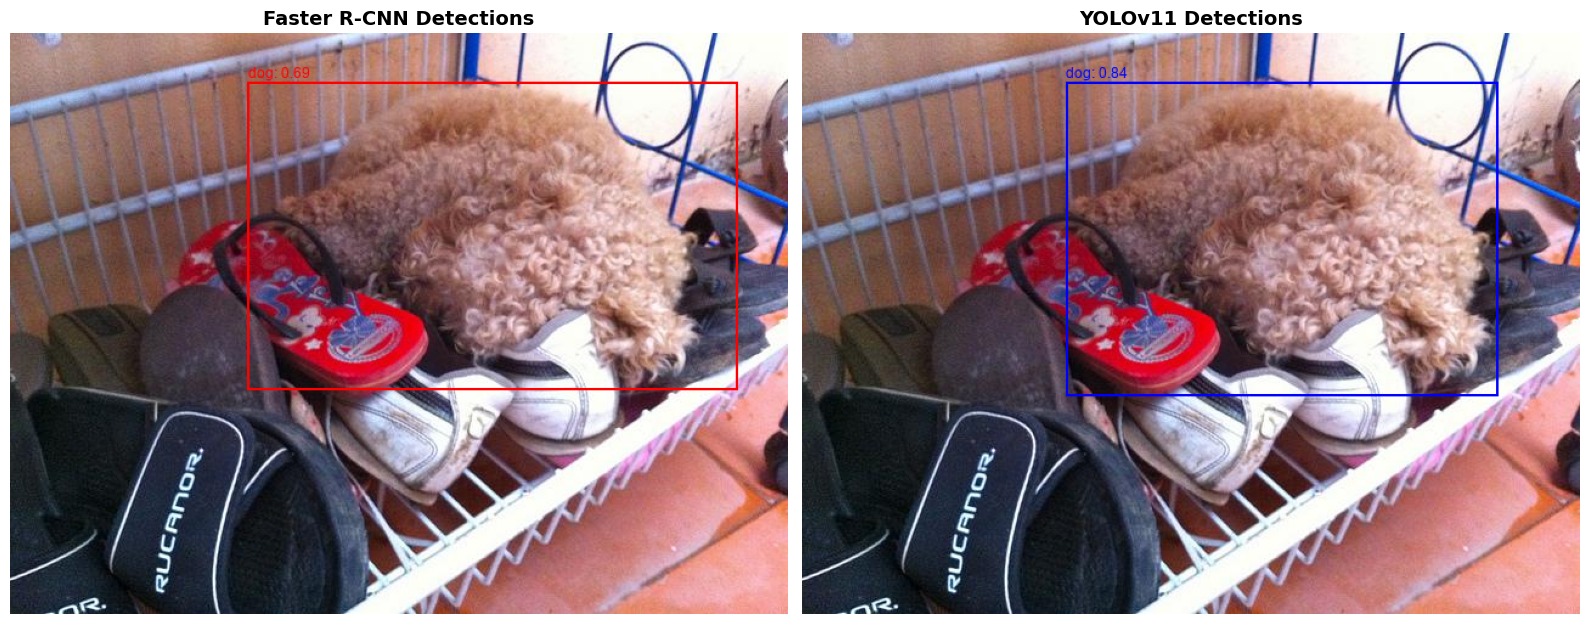


Image 11: 000000000072.jpg
  Faster R-CNN detected 2 objects
  YOLOv11 detected 2 objects


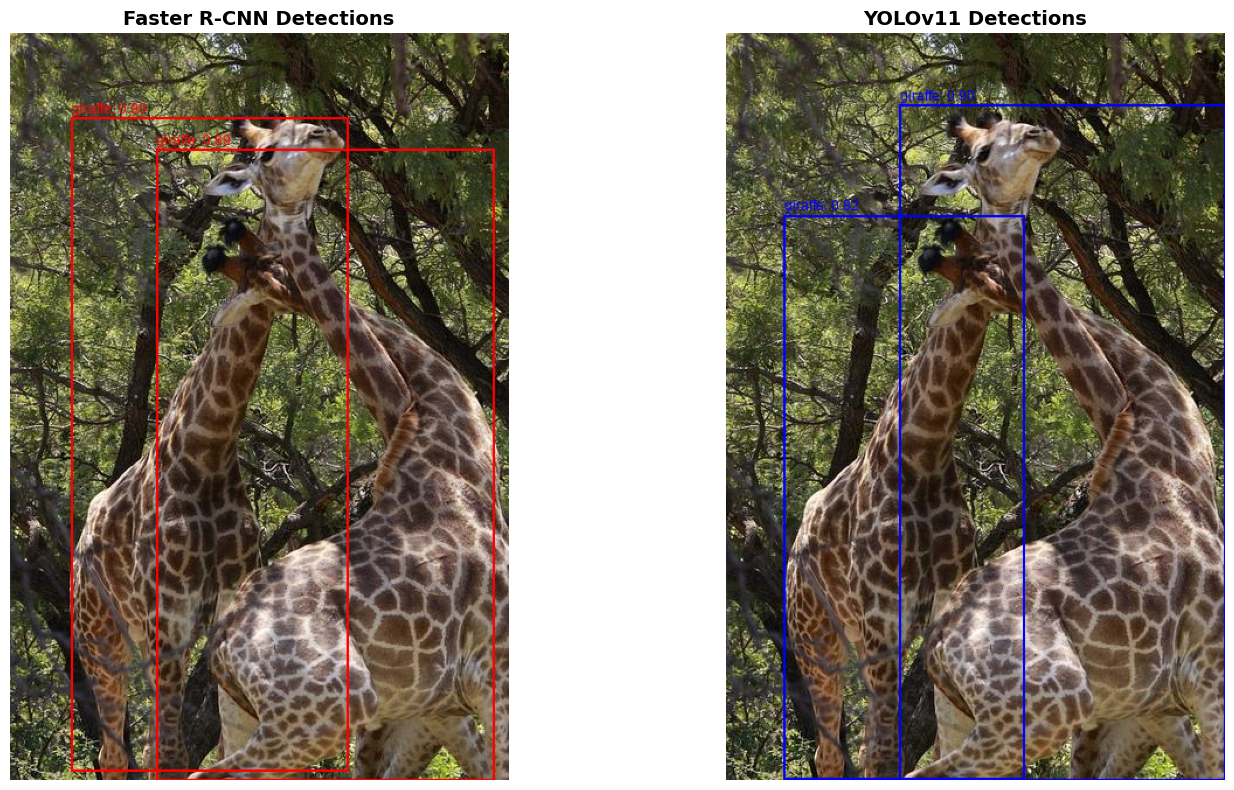


Image 21: 000000000109.jpg
  Faster R-CNN detected 8 objects
  YOLOv11 detected 2 objects


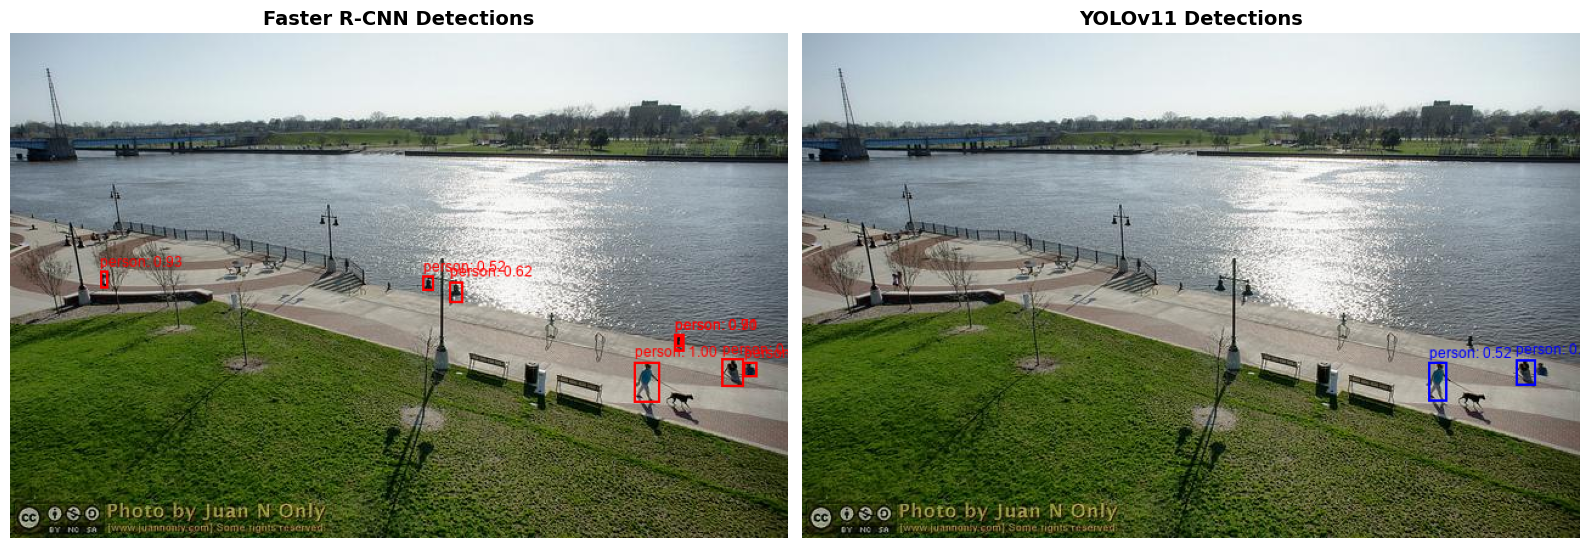


Image 31: 000000000149.jpg
  Faster R-CNN detected 18 objects
  YOLOv11 detected 3 objects


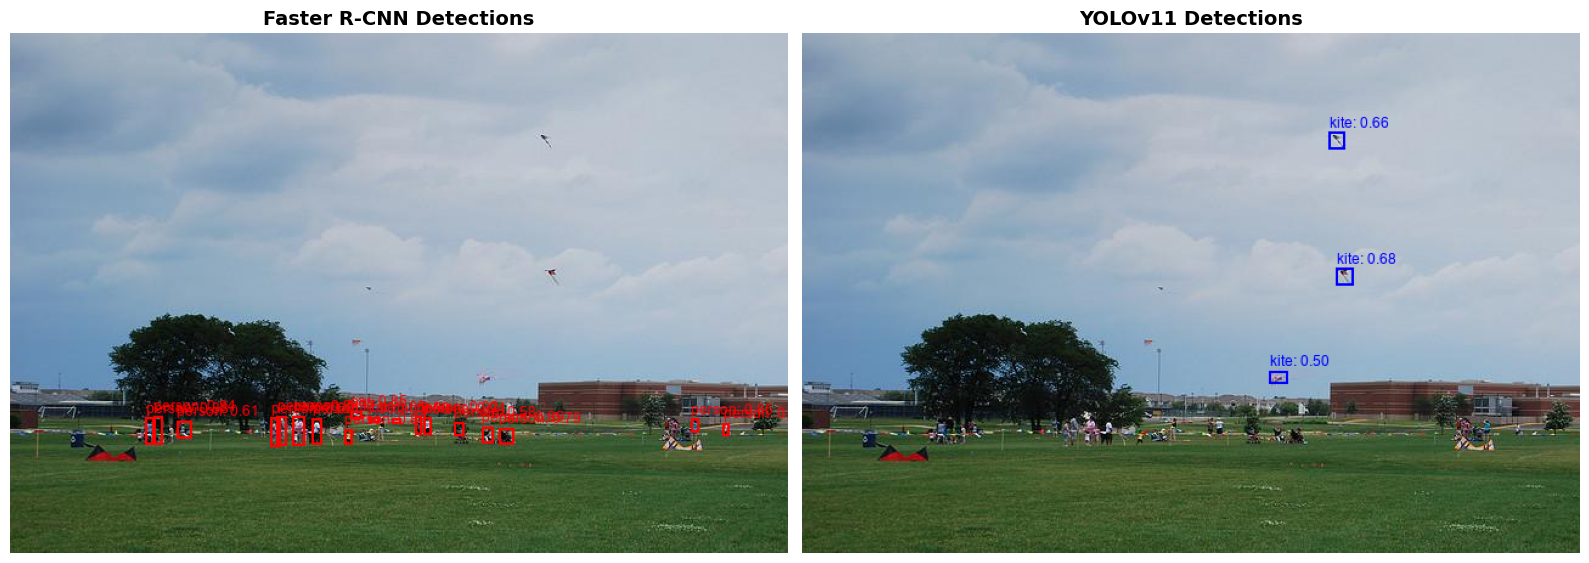


Image 51: 000000000309.jpg
  Faster R-CNN detected 1 objects
  YOLOv11 detected 4 objects


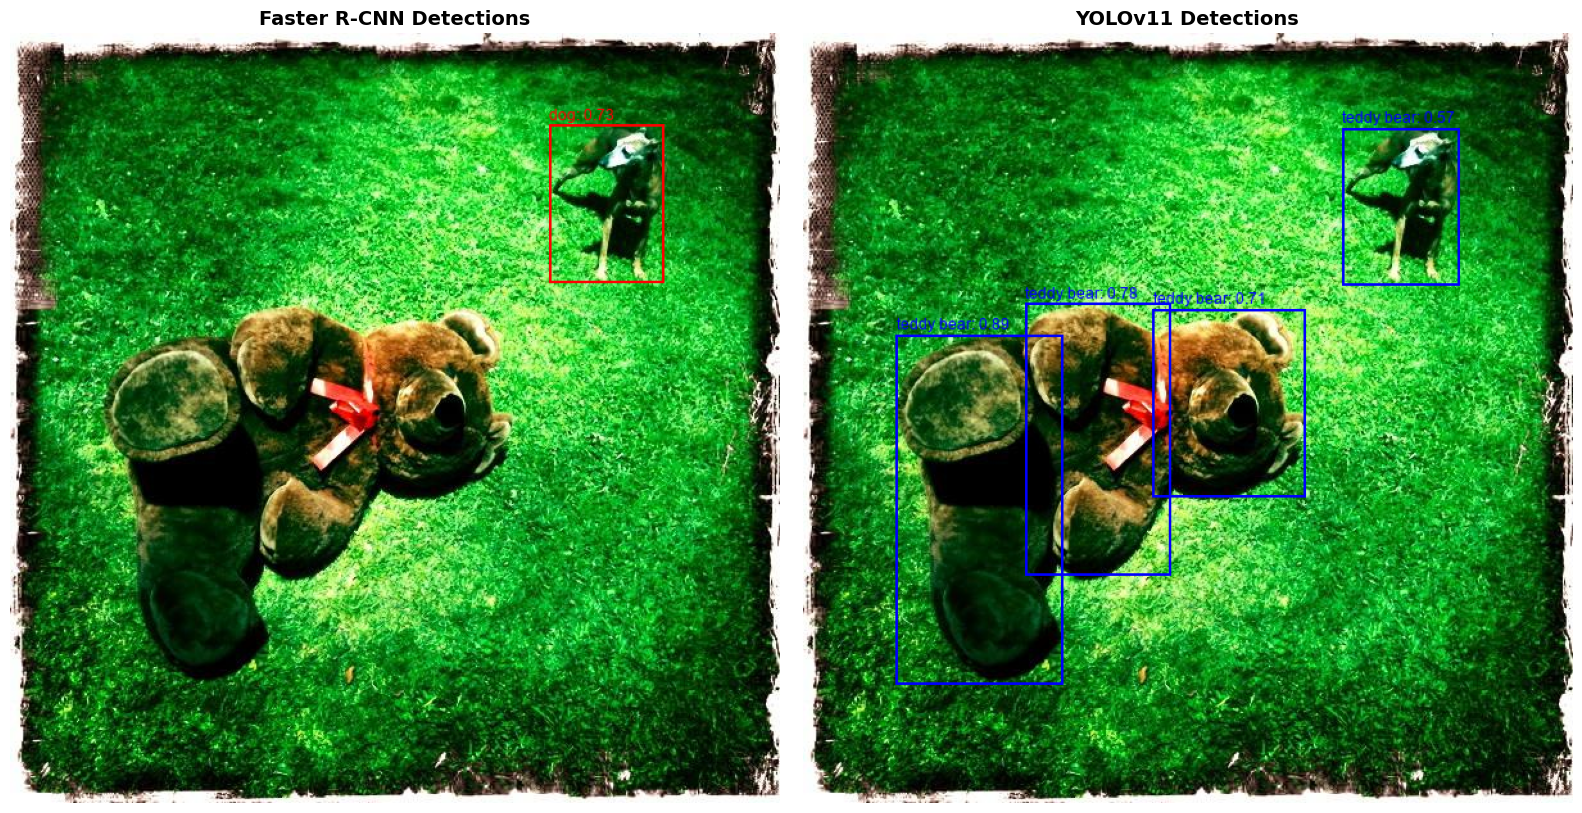


Image 71: 000000000395.jpg
  Faster R-CNN detected 11 objects
  YOLOv11 detected 4 objects


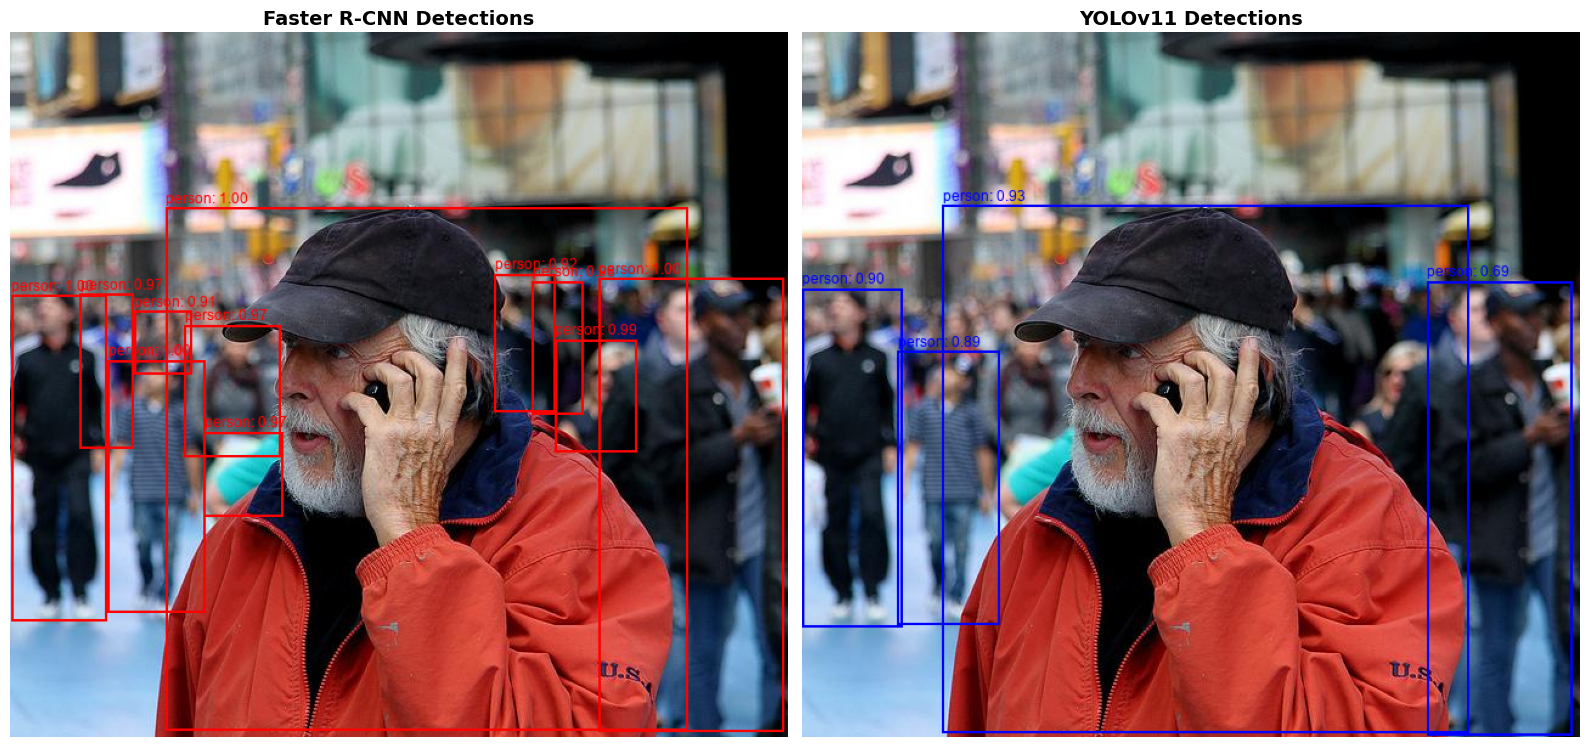


Image 91: 000000000491.jpg
  Faster R-CNN detected 2 objects
  YOLOv11 detected 3 objects


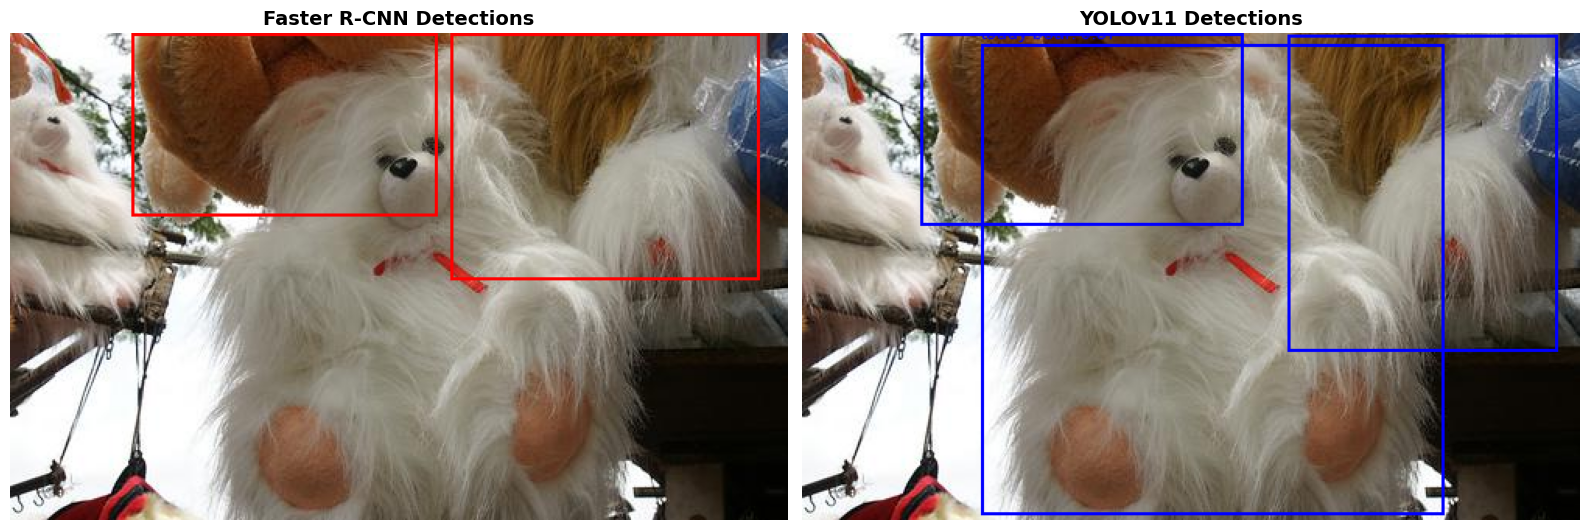

In [26]:
# Visualize detections on 8 sample images
print("Visualizing detections on sample images...")

# Select diverse images with different numbers of objects
sample_indices = [0, 5, 10, 20, 30, 50, 70, 90]
conf_threshold = 0.5

for idx in sample_indices[:8]:  # Visualize 8 images
    if idx >= len(dataset):
        break
    
    sample = dataset[idx]
    image_path = sample['image_path']
    
    print(f"\nImage {idx + 1}: {os.path.basename(image_path)}")
    
    # Get predictions
    rcnn_boxes, rcnn_labels, rcnn_scores = run_faster_rcnn(faster_rcnn, image_path, conf_threshold)
    yolo_boxes, yolo_labels, yolo_scores = run_yolo(yolo_model, image_path, conf_threshold)
    
    print(f"  Faster R-CNN detected {len(rcnn_boxes)} objects")
    print(f"  YOLOv11 detected {len(yolo_boxes)} objects")
    
    # Visualize
    visualize_detections(image_path, rcnn_boxes, rcnn_labels, rcnn_scores,
                        yolo_boxes, yolo_labels, yolo_scores, conf_threshold)

## Optional: Test reduced input resolutions or lightweight model variants.

In [27]:
# Test with reduced input resolution
print("Testing with reduced input resolutions...")

# Test different image sizes
test_sizes = [320, 416, 640]
size_results = {'size': [], 'rcnn_fps': [], 'yolo_fps': []}

for size in test_sizes:
    print(f"\nTesting with image size: {size}x{size}")
    
    # Prepare resized images
    test_subset = image_files[:20]  # Use smaller subset for speed
    
    # Faster R-CNN with resized images
    start_time = time.time()
    for img_name in test_subset:
        img_path = os.path.join(images_path, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Resize while maintaining aspect ratio
        image.thumbnail((size, size), Image.Resampling.LANCZOS)
        
        # Save temporarily and run inference
        temp_path = 'temp_resized.jpg'
        image.save(temp_path)
        _ = run_faster_rcnn(faster_rcnn, temp_path, conf_threshold=0.5)
    
    rcnn_time = time.time() - start_time
    rcnn_fps = len(test_subset) / rcnn_time
    
    # YOLOv11 with resized images
    start_time = time.time()
    for img_name in test_subset:
        img_path = os.path.join(images_path, img_name)
        image = Image.open(img_path).convert('RGB')
        image.thumbnail((size, size), Image.Resampling.LANCZOS)
        temp_path = 'temp_resized.jpg'
        image.save(temp_path)
        _ = run_yolo(yolo_model, temp_path, conf_threshold=0.5)
    
    yolo_time = time.time() - start_time
    yolo_fps = len(test_subset) / yolo_time
    
    size_results['size'].append(f'{size}x{size}')
    size_results['rcnn_fps'].append(f'{rcnn_fps:.2f}')
    size_results['yolo_fps'].append(f'{yolo_fps:.2f}')
    
    print(f"  Faster R-CNN: {rcnn_fps:.2f} FPS")
    print(f"  YOLOv11: {yolo_fps:.2f} FPS")

# Clean up temp file
if os.path.exists('temp_resized.jpg'):
    os.remove('temp_resized.jpg')

# Display results table
size_df = pd.DataFrame(size_results)
size_df.columns = ['Input Size', 'Faster R-CNN FPS', 'YOLOv11 FPS']
print("\n" + "="*50)
print("RESOLUTION COMPARISON")
print("="*50)
print(size_df.to_string(index=False))
print("="*50)

Testing with reduced input resolutions...

Testing with image size: 320x320
  Faster R-CNN: 14.55 FPS
  YOLOv11: 38.41 FPS

Testing with image size: 416x416
  Faster R-CNN: 14.25 FPS
  YOLOv11: 36.20 FPS

Testing with image size: 640x640
  Faster R-CNN: 14.60 FPS
  YOLOv11: 39.69 FPS

RESOLUTION COMPARISON
Input Size Faster R-CNN FPS YOLOv11 FPS
   320x320            14.55       38.41
   416x416            14.25       36.20
   640x640            14.60       39.69


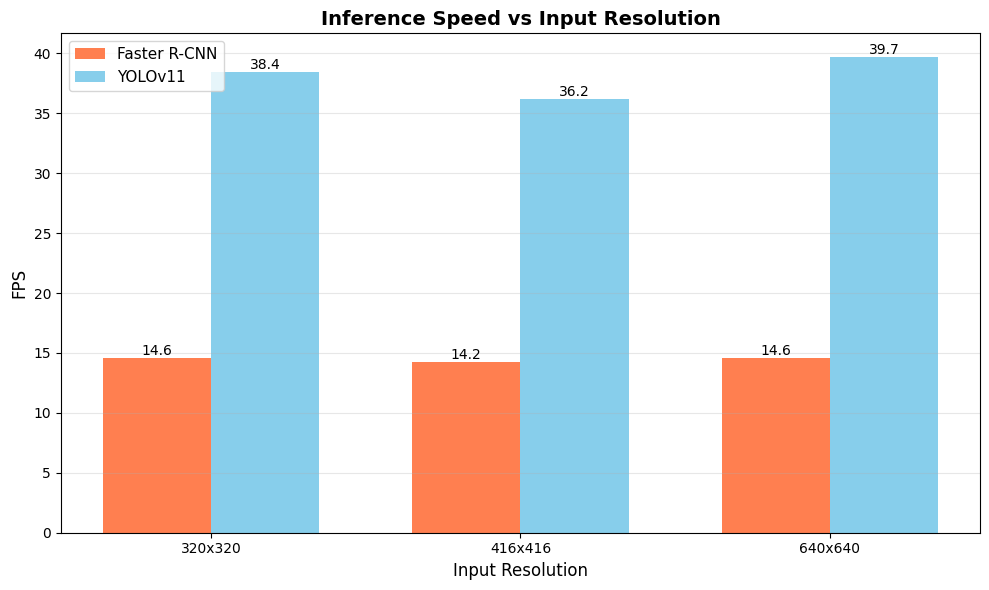

In [28]:
# Plot FPS comparison across different resolutions
fig, ax = plt.subplots(figsize=(10, 6))

sizes = [320, 416, 640]
rcnn_fps_values = [float(size_results['rcnn_fps'][i]) for i in range(len(sizes))]
yolo_fps_values = [float(size_results['yolo_fps'][i]) for i in range(len(sizes))]

x = np.arange(len(sizes))
width = 0.35

bars1 = ax.bar(x - width/2, rcnn_fps_values, width, label='Faster R-CNN', color='coral')
bars2 = ax.bar(x + width/2, yolo_fps_values, width, label='YOLOv11', color='skyblue')

ax.set_xlabel('Input Resolution', fontsize=12)
ax.set_ylabel('FPS', fontsize=12)
ax.set_title('Inference Speed vs Input Resolution', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{s}x{s}' for s in sizes])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [29]:
# Consolidated tables display: training metrics, quantitative comparison, and resolution comparison
from IPython.display import display, HTML
import pandas as pd
import os

print("\n" + "="*70)
print("ALL TABLES SUMMARY")
print("="*70)

# Helper to show a titled table
def show_table(title, df):
    display(HTML(f"<h3 style='margin:8px 0'>{title}</h3>"))
    try:
        display(df.style.set_properties(**{"text-align": "right"}).set_table_styles([
            {"selector": "th", "props": [("text-align", "left")]},
            {"selector": "table", "props": [("margin", "0 0 16px 0")]}
        ]))
    except Exception:
        display(df)

# 1) YOLOv11 training metrics (last 5 epochs)
yolo_results_path = 'model_task2/yolov11n_coco128_run/results.csv'
if os.path.exists(yolo_results_path):
    yolo_df = pd.read_csv(yolo_results_path)
    # normalize column names
    yolo_df.columns = [c.strip() for c in yolo_df.columns]
    cols = [c for c in ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)'] if c in yolo_df.columns]
    show_table('YOLOv11 Training Metrics (last 5 epochs)', yolo_df[cols].tail(5).reset_index(drop=True))
else:
    display(HTML("<p>YOLOv11 results.csv not found.</p>"))

# 2) Faster R-CNN training metrics (last 5 epochs)
rcnn_results_path = 'model_task2/faster_rcnn_training_results.csv'
if os.path.exists(rcnn_results_path):
    rcnn_df = pd.read_csv(rcnn_results_path)
    cols = [c for c in ['epoch', 'train/total_loss', 'train/box_loss', 'train/cls_loss'] if c in rcnn_df.columns]
    show_table('Faster R-CNN Training Metrics (last 5 epochs)', rcnn_df[cols].tail(5).reset_index(drop=True))
else:
    # fallback to variables if present
    if 'training_losses' in globals():
        tmp_df = pd.DataFrame({
            'epoch': list(range(1, len(training_losses)+1)),
            'train/total_loss': training_losses
        })
        show_table('Faster R-CNN Training Losses (in-memory)', tmp_df.tail(5).reset_index(drop=True))
    else:
        display(HTML("<p>Faster R-CNN training metrics not available.</p>"))

# 3) Quantitative comparison table
if 'comparison_df' in globals():
    show_table('Quantitative Comparison (Model Size, mAP, Speed, Memory)', comparison_df)
else:
    # Try reconstruct minimal comparison from available variables
    try:
        comparison_data = {
            'Metric': [
                'Model Type', 'Parameters (M)', 'Model Size (MB)', 'mAP@0.5',
                'Inference Speed (FPS)', 'Avg Time per Image (ms)', 'Peak GPU Memory (MB)'
            ],
            'Faster R-CNN': [
                'Two-Stage', f"{faster_rcnn_size:.2f}", f"{faster_rcnn_file_size:.2f}",
                f"{rcnn_ap:.4f}", f"{rcnn_fps:.2f}", f"{rcnn_time/num_test*1000:.2f}", f"{rcnn_memory:.2f}"
            ],
            'YOLOv11': [
                'Single-Stage', f"{yolo_size:.2f}", f"{yolo_file_size:.2f}",
                f"{yolo_ap:.4f}", f"{yolo_fps:.2f}", f"{yolo_time/num_test*1000:.2f}", f"{yolo_memory:.2f}"
            ]
        }
        comparison_df2 = pd.DataFrame(comparison_data)
        show_table('Quantitative Comparison (Model Size, mAP, Speed, Memory)', comparison_df2)
    except Exception:
        display(HTML("<p>Quantitative comparison variables not available to reconstruct table.</p>"))

# 4) Resolution (input size) vs FPS comparison table
if 'size_df' in globals():
    show_table('Resolution Comparison (Input Size vs FPS)', size_df)
elif 'size_results' in globals() and size_results:
    try:
        size_df2 = pd.DataFrame(size_results)
        size_df2.columns = ['Input Size', 'Faster R-CNN FPS', 'YOLOv11 FPS']
        show_table('Resolution Comparison (Input Size vs FPS)', size_df2)
    except Exception:
        display(HTML("<p>Resolution comparison data structure not valid.</p>"))
else:
    display(HTML("<p>Resolution comparison table not available.</p>"))

print("="*70)
print("End of tables summary")
print("="*70)


ALL TABLES SUMMARY


End of tables summary


## Short discussion on performance trade-offs